# Chicago crime dataset analysis 
This Notebook contains Chicago crime data analysis for the last ten years (2011-2021) <br>
The dataset was collected from the ‘city of chicago’ official website which has many public datasets.<br>

## Dataset Description
For this particular project I have used three datasets ,the first dataset is the actual crime dataset which contains information about the crime that is time, location, category and primary type. The second dataframe is about the districts in chicago which contains district name and chicago district number which I will further use for getting an comprehensive idea about the crimes in chicago based on different districts. The dataset consists of 22 columns and 7.5 Million rows (dataset size 1.78GB). The dataset has information about the
reported crimes from 2001 in the city of chicago except for the murders.

* The dataset about the crime and IUCR can be found in the Chicago's official [website.](https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q)
* The dataset which had information about disricts was also from the same portal. 

--- 

<br>

The aim of the project is to find out the crimes which occured more often, find the crime rate trend across the years and during which month and hour of the day crime rate was highest. Using the second dataset I want to get the district naes and join the two dataframes so that we can evaluate the crimes based on district. Intitially the dataset had many null values and even the schema was not properly defined so I have to perform EDA before I do any transformation on the data. As the spark doesn't have any inbuilt libraries for plotting I will be using matplotlib to plot and I will be also using sql functions to effectively work on dataframe. 

### Importing all the useful Libraries

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv
from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
from pyspark.sql.functions import *


In [2]:
from pyspark.sql import functions as F

In [3]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

### Defining the schema

In [6]:
crime_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", IntegerType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

### Reading the dataframe (First Dataframe)

In [7]:
df1 = spark.read.csv("crime_chicago.csv",sep=",", header=True, nullValue='NA', schema=crime_schema)

In [14]:
df1.show()

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|       9|

<b>We can see there are many records that have null values and even some columns are not useful, in the next steps we will be cleaning the dataset for further analysis.<b>

In [15]:
!wc -l crime_chicago.csv

7495190 crime_chicago.csv


Looking at the features

In [16]:
df1.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Counting the number of null values

In [17]:
from pyspark.sql.functions import isnan, when, count, col
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()


+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          4|   0|    0|   0|           0|          0|                9023|     0|       0|   0|      47|614840|        613478|       0|       77307|       77307|   0|   7495189|   77307|    77307|   77307|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

### For better understanding I have only considered last ten years data

In [20]:
last_ten_years=['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']

In [21]:
df2=df1.filter(df1.Year.isin(last_ten_years))

In [22]:
df2.select(F.countDistinct("Year")).show()

+--------------------+
|count(DISTINCT Year)|
+--------------------+
|                  11|
+--------------------+



In [23]:
df2.select([count(when(col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          1|   0|    0|   0|           0|          0|                8707|     0|       0|   0|       1|  68|           212|       0|       30527|       30527|   0|   3021616|   30527|    30527|   30527|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

### Different crime types
Before we actually analyze the data its importnat to get an idea about the data so here we can get an idea about different crimes happening across chicago, based on this we can remove crimes that are not imperative and I will try to merge the crimes which are similar. 

In [24]:
df2.select('Primary Type').distinct().rdd.map(lambda r: r[0]).collect()

['OFFENSE INVOLVING CHILDREN',
 'CRIMINAL SEXUAL ASSAULT',
 'STALKING',
 'PUBLIC PEACE VIOLATION',
 'OBSCENITY',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'ARSON',
 'GAMBLING',
 'CRIMINAL TRESPASS',
 'ASSAULT',
 'NON - CRIMINAL',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'THEFT',
 'BATTERY',
 'ROBBERY',
 'HOMICIDE',
 'PUBLIC INDECENCY',
 'CRIM SEXUAL ASSAULT',
 'HUMAN TRAFFICKING',
 'INTIMIDATION',
 'PROSTITUTION',
 'DECEPTIVE PRACTICE',
 'CONCEALED CARRY LICENSE VIOLATION',
 'SEX OFFENSE',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'NON-CRIMINAL',
 'OTHER OFFENSE',
 'KIDNAPPING',
 'BURGLARY',
 'WEAPONS VIOLATION',
 'OTHER NARCOTIC VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'RITUALISM']

In [ ]:
df1.count()

7495189

In [ ]:
df2.count()

3021616

Before and after trimming the data based on the years we can observe the difference in number of records.

### Dropping columns which are unecessary

In [27]:
dataset = df2.drop('Case Number')\
            .drop('FBI Code')\
            .drop('Updated On')

In [28]:
dataset = dataset.na.drop()

In [29]:
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+------------+------------+----+--------+---------+--------+
| ID|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|X Coordinate|Y Coordinate|Year|Latitude|Longitude|Location|
+---+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+------------+------------+----+--------+---------+--------+
|  0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|   0|             0|           0|           0|   0|       0|        0|       0|
+---+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+------------+------------+----+--------+---------+--------+



#### Removing all the unecessary crime types 

In [30]:
dataset=dataset.filter((dataset["Primary Type"]  !=  'NON-CRIMINAL (SUBJECT SPECIFIED)') & 
               (dataset["Primary Type"]  !=  'OTHER OFFENSE') &
               (dataset["Primary Type"]  !=  'STALKING')&
               (dataset["Primary Type"]  !=  'NON - CRIMINAL')&
               (dataset["Primary Type"]  !=  'ARSON'))  

#### Merging the crime types which are similar

In [31]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'SEX OFFENSE') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'CRIM SEXUAL ASSAULT').otherwise(dataset['Primary Type']))

In [159]:
primaryCount = dataset.groupby('Primary Type').count()
print('Different type of crimes which occur more')
primaryCount.orderBy('count', ascending=False).show()

Different type of crimes which occur more
+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|669273|
|             BATTERY|552073|
|     CRIMINAL DAMAGE|324105|
|           NARCOTICS|222543|
|             ASSAULT|209507|
|  DECEPTIVE PRACTICE|167464|
|            BURGLARY|158858|
| MOTOR VEHICLE THEFT|130240|
|             ROBBERY|115942|
|   CRIMINAL TRESPASS| 73231|
|   WEAPONS VIOLATION| 54740|
| CRIM SEXUAL ASSAULT| 35260|
|OFFENSE INVOLVING...| 23715|
|PUBLIC PEACE VIOL...| 22391|
|INTERFERENCE WITH...| 12095|
|            HOMICIDE|  6488|
|CRIMINAL SEXUAL A...|  3679|
|LIQUOR LAW VIOLATION|  3581|
|            GAMBLING|  3520|
|          KIDNAPPING|  2092|
+--------------------+------+
only showing top 20 rows



## The top ten crimes in chicago 

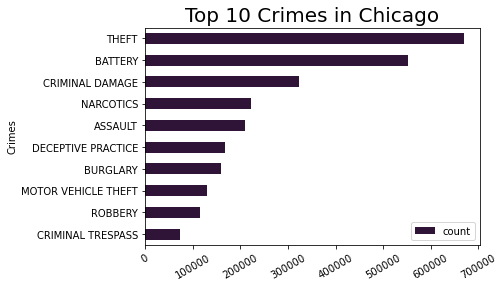

In [33]:
pdf = primaryCount.toPandas()
pdf = pdf.sort_values(by="count", ascending= True)
pdf = pdf.tail(10)
pdf.plot(kind='barh', x='Primary Type', y='count', colormap='twilight_shifted')
plt.title("Top 10 Crimes in Chicago", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.ylabel('Crimes')
plt.xticks(rotation=30)
plt.show()

In [34]:
year_wise = dataset.groupBy(['Year'])\
                     .count()\
                     .orderBy(['Year', 'count'], ascending=[True, False])
print()
year_wise.show(10, truncate=False)


+----+------+
|Year|count |
+----+------+
|2011|330055|
|2012|316943|
|2013|287827|
|2014|256118|
|2015|239871|
|2016|248581|
|2017|246547|
|2018|245299|
|2019|240820|
|2020|194254|
+----+------+
only showing top 10 rows



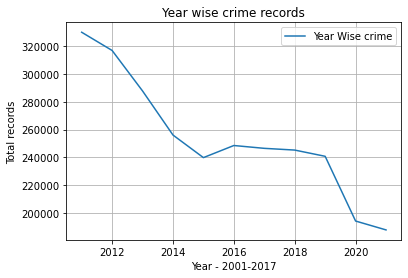

In [35]:
year_wise = year_wise.toPandas()
fig, ax = plt.subplots()
ax.plot(year_wise['Year'], year_wise['count'], label='Year Wise crime')
ax.set(xlabel='Year - 2001-2017', ylabel='Total records',
       title='Year wise crime records')
ax.grid(which='both', axis='both')
ax.legend()

In [36]:
dataset = dataset.withColumn('datetime', to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))

In [37]:
#dataset = dataset.withColumn("datetime", trunc(col("datetime"),"Month").alias("Month"))

In [38]:
mon_wise = dataset.select("datetime", month(col("datetime")).alias("dmonth"), )

In [39]:
monthcount = mon_wise.groupby('dmonth').count()
monthcount.orderBy('dmonth', ascending=True).show()

+------+------+
|dmonth| count|
+------+------+
|     1|219317|
|     2|190191|
|     3|224068|
|     4|221165|
|     5|249106|
|     6|252011|
|     7|263232|
|     8|260098|
|     9|241842|
|    10|240443|
|    11|218085|
|    12|214624|
+------+------+



In [40]:
dfm = monthcount.orderBy('dmonth', ascending=True)

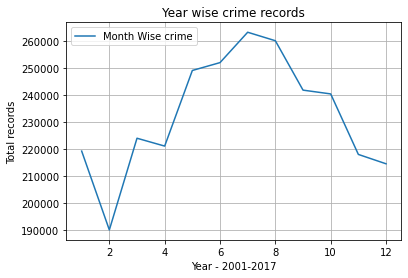

In [41]:
dfm = dfm.toPandas()
fig, ax = plt.subplots()
ax.plot(dfm['dmonth'], dfm['count'], label='Month Wise crime')
ax.set(xlabel='Year - 2001-2017', ylabel='Total records',
       title='Year wise crime records')
ax.grid(which='both', axis='both')
ax.legend()

In [ ]:
only_hrs = dataset.select("datetime", hour(col("datetime")).alias("dhour"), )

In [ ]:
hrs_count = only_hrs.groupby('dhour').count()
hrs_count = hrs_count.orderBy('dhour', ascending=True)

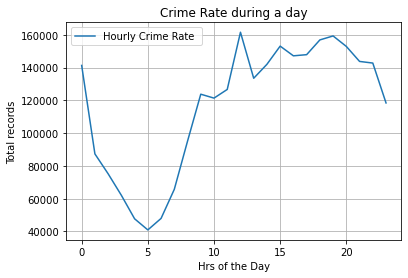

In [90]:
hrs_count = hrs_count.toPandas()
fig, ax = plt.subplots()
ax.plot(hrs_count['dhour'], hrs_count['count'], label='Hourly Crime Rate ')
ax.set(xlabel='Hrs of the Day', ylabel='Total records',
       title='Crime Rate during a day')
ax.grid(which='both', axis='both')
ax.legend()

In [44]:
dis_list= ['31','12','22','1','6','16','3','20','5','19','15','9','17','4','8','7','10','25','24','11','14','2','18','21']

In [45]:
distrtict = spark.read.csv("Police_Stations.csv",sep=",", header=True, nullValue='NA')

In [46]:
district = distrtict.filter(distrtict.DISTRICT.isin(dis_list))

In [47]:
district = district.withColumn("DISTRICT", district["DISTRICT"].cast(IntegerType()))

In [48]:
dis_mer_df = dataset.filter(dataset.District.isin(dis_list))

In [49]:
district = district.select('DISTRICT','DISTRICT NAME')

In [50]:
dis_mer_df = dis_mer_df.select('District')

In [51]:
district_df = dis_mer_df.join(district,dis_mer_df.District == district.DISTRICT,"inner")

In [52]:
district.printSchema()

root
 |-- DISTRICT: integer (nullable = true)
 |-- DISTRICT NAME: string (nullable = true)



In [67]:
dcount = district_df.groupby('DISTRICT NAME').count()
dcount.orderBy("count", ascending=False).show()

+--------------+------+
| DISTRICT NAME| count|
+--------------+------+
|      Harrison|195003|
|  Chicago Lawn|180590|
|       Gresham|171141|
| South Chicago|159920|
|     Englewood|156677|
| Grand Central|152445|
|Grand Crossing|137621|
|     Near West|137154|
|    Near North|136407|
|       Deering|130967|
|       Central|129786|
|     Town Hall|128037|
|         Ogden|127894|
|       Calumet|124458|
|     Wentworth|118537|
|        Austin|117776|
|   Shakespeare|101129|
|Jefferson Park| 91124|
|   Morgan Park| 89480|
|   Rogers Park| 80994|
+--------------+------+
only showing top 20 rows



In [68]:
dcount = dcount.orderBy("count", ascending=False)

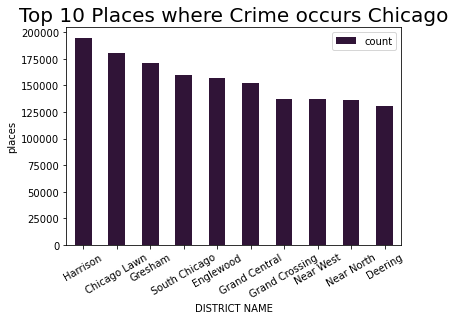

In [85]:
dcount = dcount.toPandas()
dcount = dcount.head(10)
dcount.plot(kind='bar', x='DISTRICT NAME', y='count', colormap='twilight_shifted')
plt.title("Top 10 Places where Crime occurs Chicago", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.ylabel('places')
plt.xticks(rotation=30)
plt.show()

In [91]:
arrested = dataset[dataset['Arrest'] == True]
not_arrested = dataset[dataset['Arrest'] == False]

In [100]:
arrested_df = arrested.groupby('Year').count()
arrested_df = arrested_df.orderBy('Year',ascending=True)

In [102]:
not_arrested_df = not_arrested.groupby('Year').count()
not_arrested_df = not_arrested_df.orderBy('Year',ascending=True)

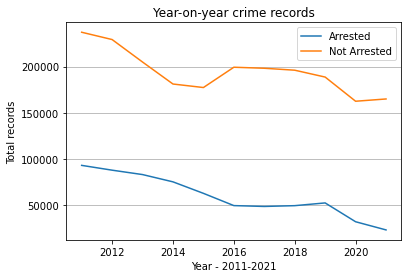

In [108]:
arrested_df = arrested_df.toPandas()
not_arrested_df = not_arrested_df.toPandas()
fig, ax = plt.subplots()
ax.plot(arrested_df['Year'], arrested_df['count'], label='Arrested')
ax.plot(not_arrested_df['Year'], not_arrested_df['count'], label='Not Arrested')

ax.set(xlabel='Year - 2011-2021', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(which='both', axis='y')
ax.legend()

In [109]:
communityarea = spark.read.csv("communityarea.csv",sep=",", header=True, nullValue='NA')

In [114]:
communityarea = communityarea.select("GEOID","GEOG")

In [116]:
communityarea = communityarea.select(col("GEOID").alias("com_num"), col("GEOG").alias("com_name"))

+-------+------------------+
|com_num|          com_name|
+-------+------------------+
|     14|       Albany Park|
|     57|    Archer Heights|
|     34|     Armour Square|
|     70|           Ashburn|
|     71|    Auburn Gresham|
|     25|            Austin|
|     45|       Avalon Park|
|     21|          Avondale|
|     19|    Belmont Cragin|
|     72|           Beverly|
|     60|        Bridgeport|
|     58|     Brighton Park|
|     47|          Burnside|
|     48|   Calumet Heights|
|     44|           Chatham|
|     66|      Chicago Lawn|
|     64|          Clearing|
|     35|           Douglas|
|     17|           Dunning|
|     27|East Garfield Park|
+-------+------------------+
only showing top 20 rows



In [130]:
dataset_com = dataset.select("Primary Type", "Community Area")
dataset_com = dataset_com.select(col("Primary Type").alias("primary"), col("Community Area").alias("c_id"))

In [149]:
com_df3 = communityarea.join(dataset_com,communityarea.com_num == dataset_com.c_id,"inner")

In [152]:
com_df1 = com_df3.groupby('com_name').count()
com_df1 = com_df1.orderBy('count',ascending=False)

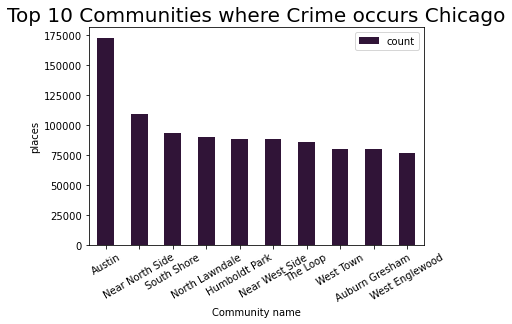

In [157]:
com_df = com_df1.toPandas()
com_df = com_df.head(10)
com_df.plot(kind='bar', x='com_name', y='count', colormap='twilight_shifted')
plt.title("Top 10 Communities where Crime occurs Chicago", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.xlabel('Community name')
plt.ylabel('places')
plt.xticks(rotation=30)
plt.show()